**ML-STIM**

*Machine Learning for SubThalamic nucleus Intraoperative Mapping*

In [1]:
## Check for GPU availability
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lib
from trained_model.MLP_architecture import MLP_STIM


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print("Running on GPU!")
else:
    print("GPU not detected. Running on CPU.")

GPU not detected. Running on CPU.


1. Data loading

In [2]:
# Path definition
filepath = "data.npz"
metapath = "metadata.csv"

with np.load(filepath) as npfh:
	raw_data = npfh['data']             # Load data matrix
meta = pd.read_csv(metapath, sep=';')   # Load metadata

print(f"Data loaded with shape: {raw_data.shape}")

Data loaded with shape: (13, 240000)


- *Display data structure*

  patient   side   electrode  depth  length  class
0     P07  RIGHT  Electrode1 -10000  240000      0
1     P07  RIGHT  Electrode1  -8000  240000      0
2     P07  RIGHT  Electrode1  -6000  240000      0


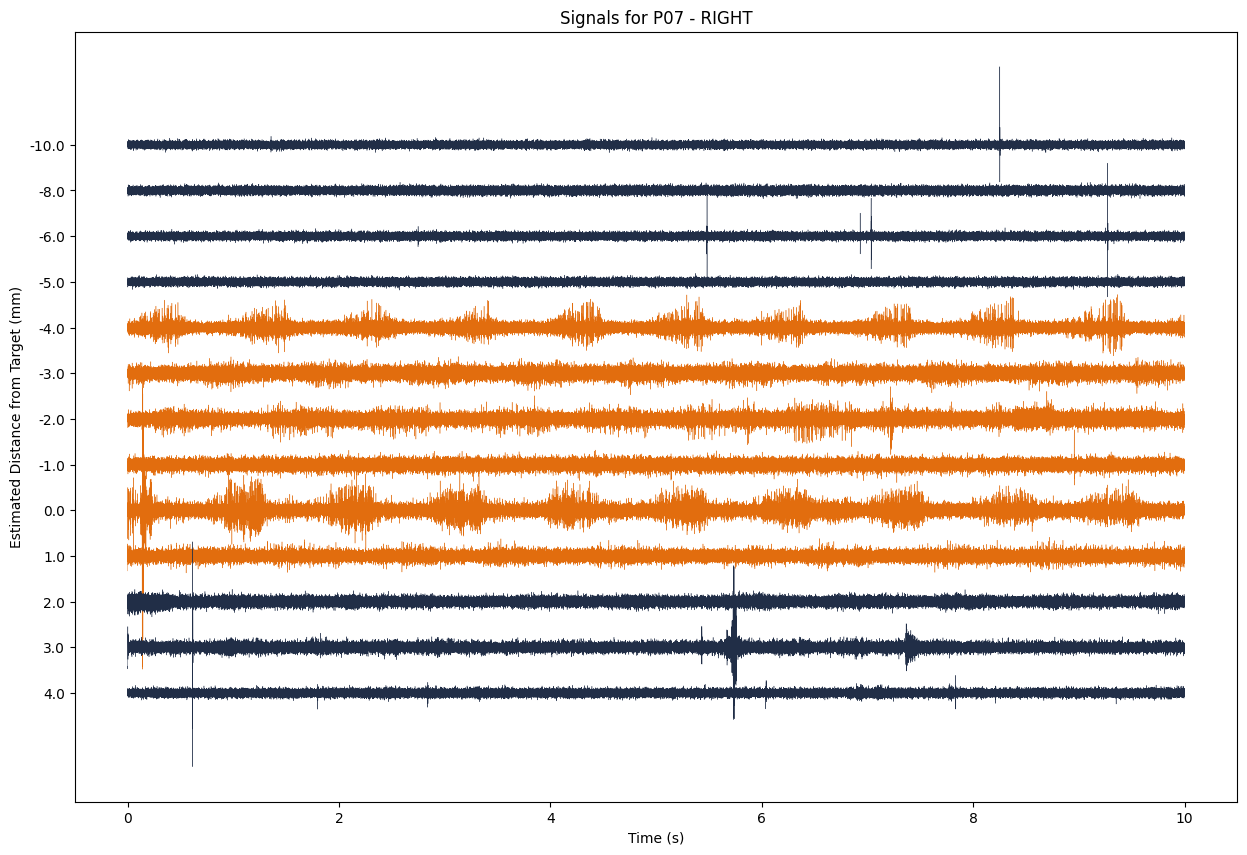

In [3]:
# Display the first 3 rows of the table meta
print(meta.head(3))

# Plot the first n signals of raw_data
lib.plot_signals('P07','RIGHT',raw_data, meta, fsamp=24000)

2. Signal processing

In [4]:
# process signal
fsamp = 24000		# Sampling frequency (Hz)
b, a = lib.initialize_filter_coefficients(fsamp)

recording = raw_data[11, :meta['length'][11]]
filtered_data = lib.filter_data(recording, b, a)
artifact_free_data, art_mask = lib.remove_artifact(filtered_data, fsamp)


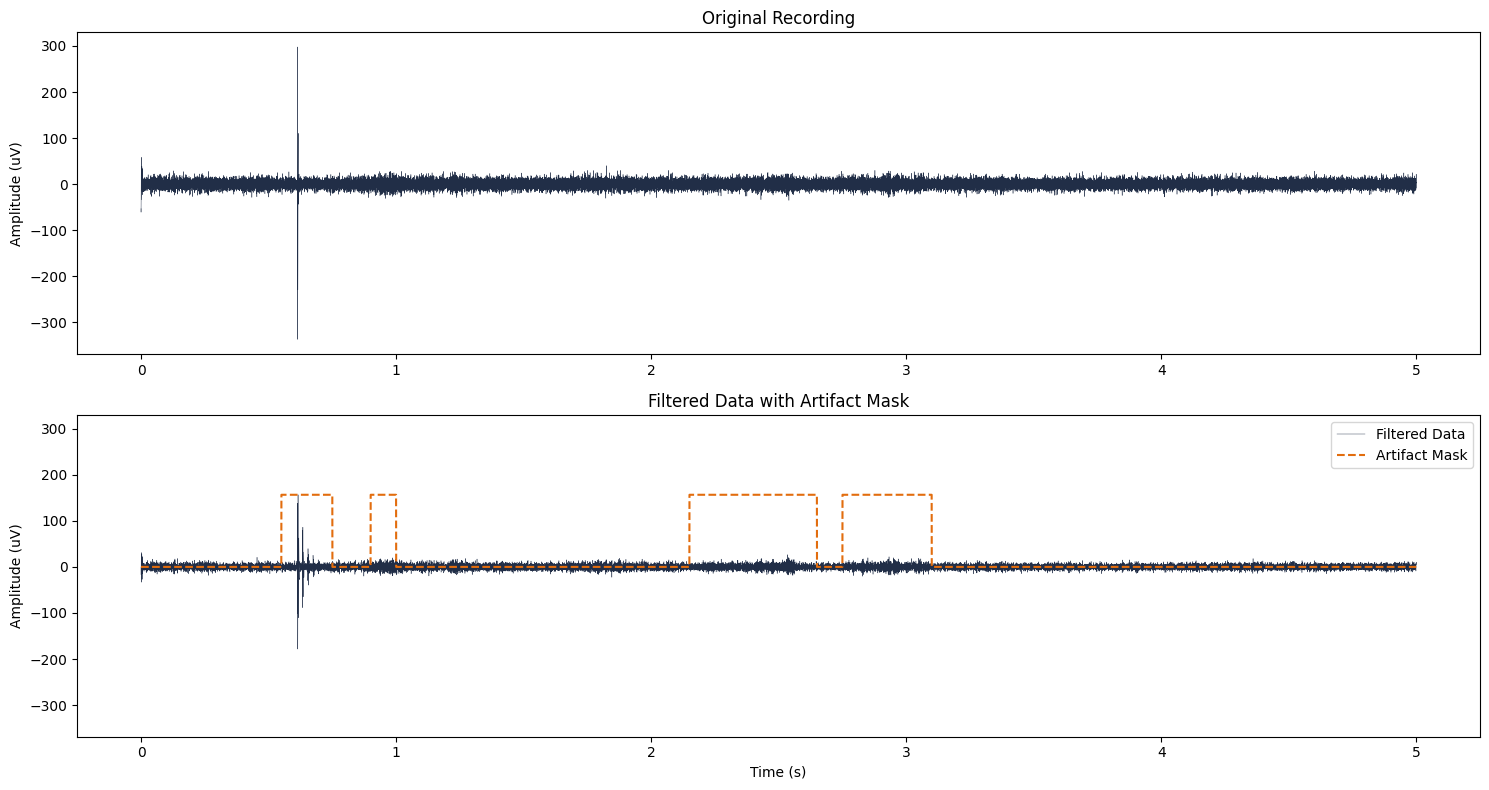

In [5]:


fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharey=True)

dt = 5*fsamp
time_vector = np.arange(dt) / fsamp
# Plot the original recording
axs[0].plot(time_vector, recording[:dt], color='#212e47', linewidth=0.3)
axs[0].set_title('Original Recording')
axs[0].set_ylabel('Amplitude (uV)')

# Plot the filtered data with artifact mask
axs[1].plot(time_vector, filtered_data[:dt], label='Filtered Data', color='#212e47', linewidth=0.3)
axs[1].plot(time_vector, art_mask[:dt] * torch.max(filtered_data[:dt]), label='Artifact Mask', linestyle='--', color='#e26d0e')
axs[1].set_title('Filtered Data with Artifact Mask')
axs[1].set_ylabel('Amplitude (uV)')
axs[1].set_xlabel('Time (s)')
axs[1].legend()

plt.tight_layout()
plt.show()

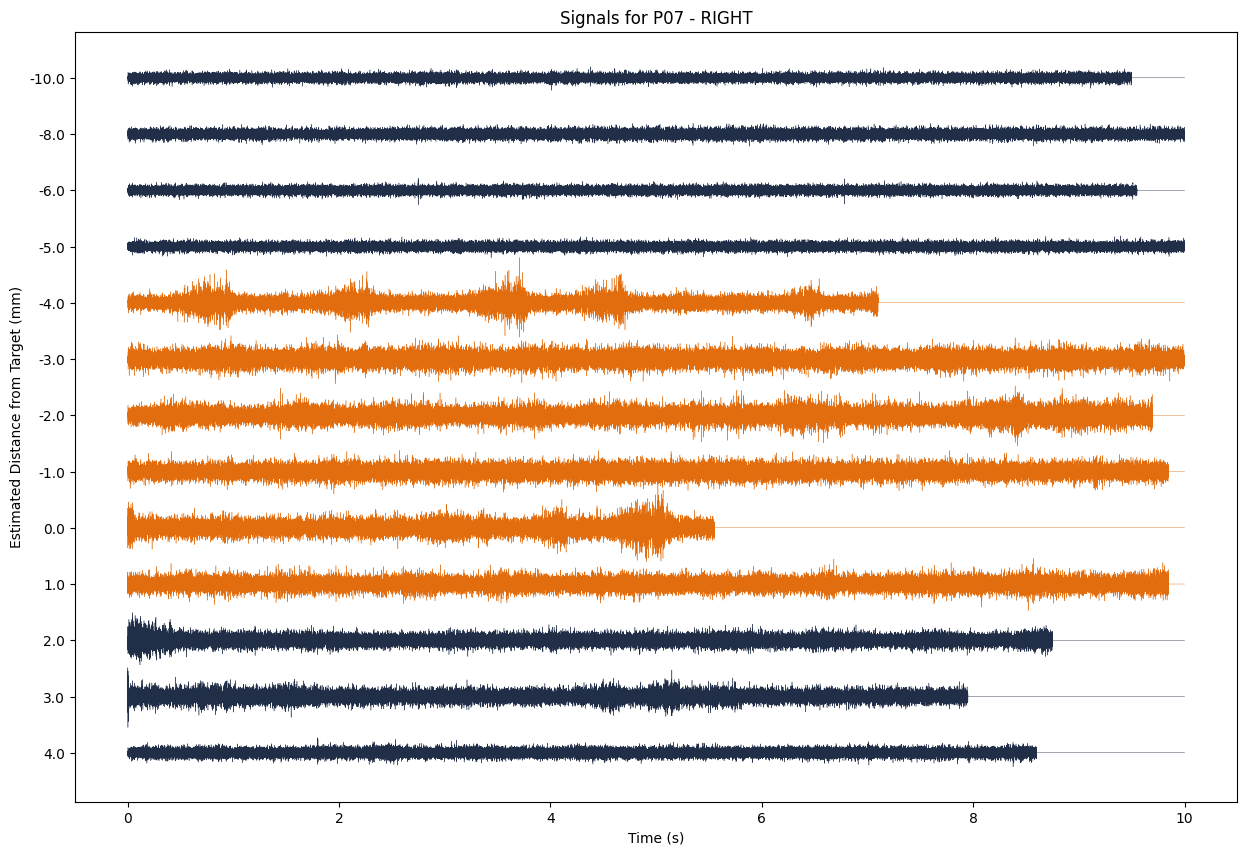

In [6]:
# Example usage
clear_data = []
meta_clear_data = meta.copy()

for i in range(raw_data.shape[0]):
    recording = raw_data[i, :meta['length'][i]]
    filtered_data = lib.filter_data(recording, b, a)
    artifact_free_data, _ = lib.remove_artifact(filtered_data, fsamp)
    meta_clear_data.loc[i, 'length'] = len(artifact_free_data)
    # Zero-padding if the signal is shorter than 240000
    if len(artifact_free_data) < 240000:
        padded_signal = np.pad(artifact_free_data, (0, 240000 - len(artifact_free_data)), 'constant')
    else:
        padded_signal = artifact_free_data[:240000]
    
    clear_data.append(padded_signal)

clear_data = np.array(clear_data)

lib.plot_signals('P07', 'RIGHT',clear_data, meta, fsamp)

3. Feature extraction

In [7]:
# Initialize an empty list to store the features
features_matrix = []

# Iterate over each row of filtered_data
for i in range(clear_data.shape[0]):
    # Extract features for the current row
    features = lib.extract_segment_features_min_max(clear_data[i,:meta_clear_data['length'][i]], fsamp)
    # Append the features to the matrix
    features = np.mean(features,axis=0)
    features_matrix.append(features)

# Convert the list to a numpy array
features_matrix = np.array(features_matrix)

print("Features matrix shape:", features_matrix.shape)

Features matrix shape: (13, 9)


4. Classification

In [8]:
# Define model Path
model_path = 'trained_model'

# Import model
model = MLP_STIM(9,1).to(device)	# Initialize empty model
params = torch.load(os.path.join(model_path,'MLP_parameters.pth'), 
                    weights_only=True, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(params)

# Classify the recording
predictions = []
for features in features_matrix:
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
    prediction = model(features_tensor)
    prediction = torch.sigmoid(prediction)
    predictions.append(prediction.cpu().detach().numpy())

predictions = np.array(predictions)
print(predictions)

[[0.03991851]
 [0.04192569]
 [0.04193143]
 [0.04674877]
 [0.7258887 ]
 [0.6276486 ]
 [0.772556  ]
 [0.5935181 ]
 [0.7056913 ]
 [0.5068133 ]
 [0.24723615]
 [0.37193236]
 [0.06431347]]


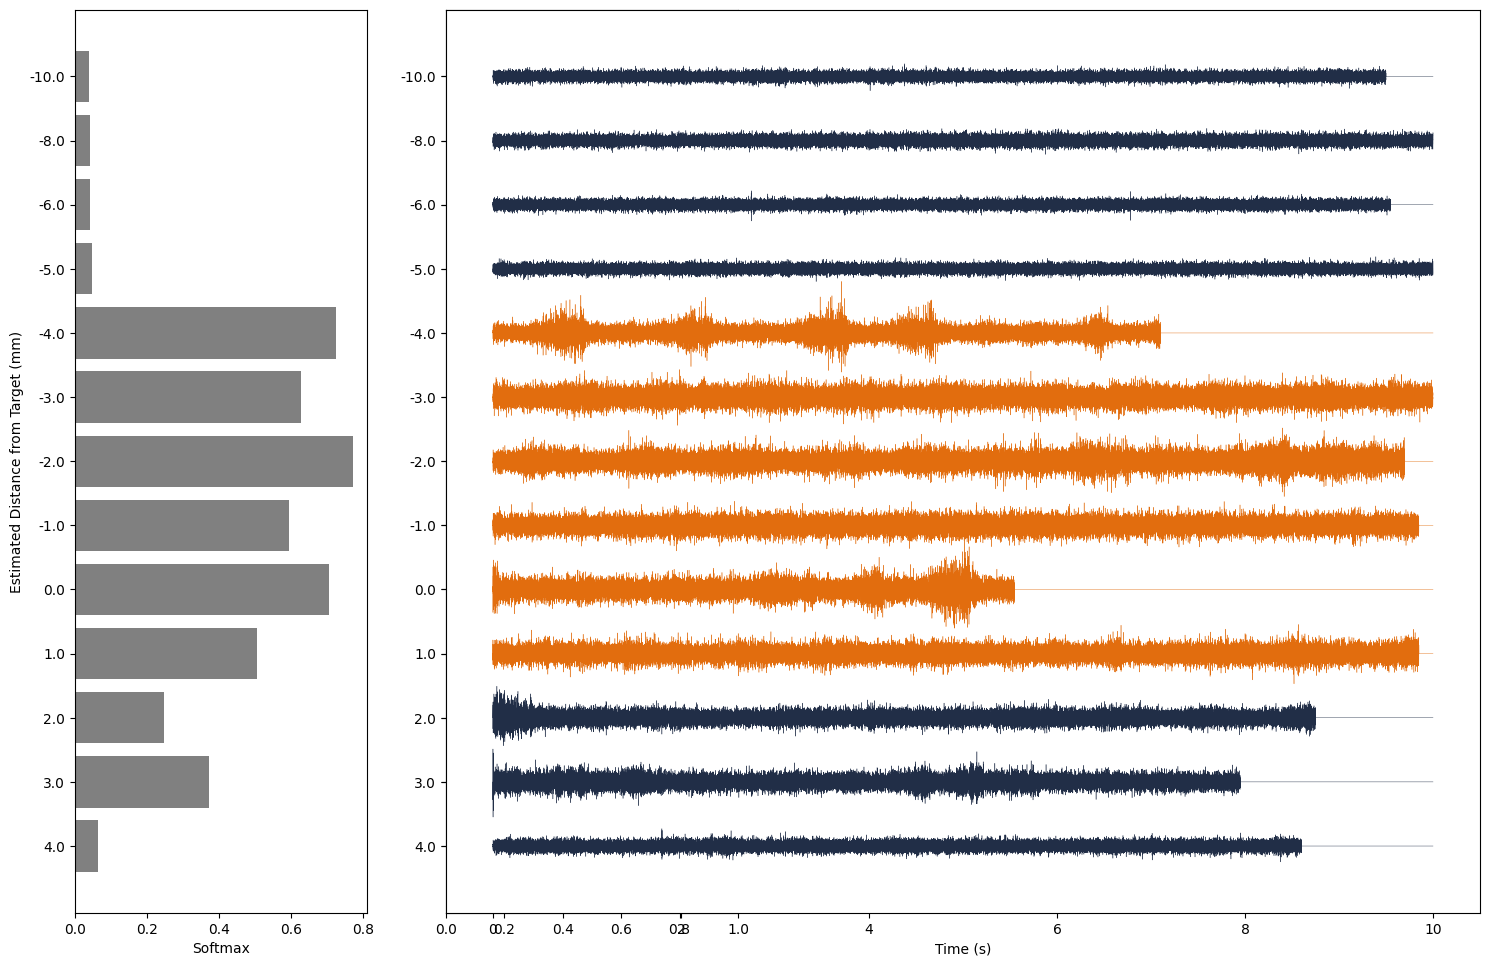

In [31]:
import matplotlib.gridspec as gridspec

fig, ax = plt.subplots(1, 4, figsize=(15, 10), sharey=True)
gs = ax[1].get_gridspec()
for ax_ in ax[2:]:
    ax_.remove()
axbig = fig.add_subplot(gs[1:], sharey=ax[0])

# Normalize signals with respect to the median standard deviation
all_signals = clear_data.copy()
median_std = np.median(np.std(all_signals))
normalized_signals = [signal / (15*median_std) for signal in all_signals]

ax[0].barh(range(0, -13, -1), predictions.flatten(), color='gray')
ax[0].set_xlabel('Softmax')
ax[0].set_ylabel('Estimated Distance from Target (mm)')
ax[0].set_yticks(-np.arange(len(normalized_signals)))
ax[0].set_yticklabels(meta['depth']/1000)  # Convert depth to mm

# Define a time vector for plotting
time_vector = np.arange(len(normalized_signals[0])) / fsamp

for i, signal in enumerate(normalized_signals):
    c = '#212e47'
    if meta.iloc[i]['class'] == 1: c = '#e26d0e'
    axbig.plot(time_vector, signal - i, linewidth=0.3, color=c)  # Offset each signal for clarity

axbig.set_yticks(-np.arange(len(normalized_signals)))
axbig.set_yticklabels(meta['depth']/1000)  # Convert depth to mm
axbig.set_xlabel('Time (s)')

fig.tight_layout()
plt.show()
